## Vehicle Detection Project

The goals / steps of this project are the following:

1) Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier  
2) Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.  
3) Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.  
4) Implement a sliding-window technique and use your trained classifier to search for vehicles in images.  
5) Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.  
6) Estimate a bounding box for vehicles detected.  

## Files Submitted

>1)./notebooks/Vehicle_Detection.ipynb
>>has exploration and vehicle detection results along with writeup text

>2)./training/Training.ipynb
>>contains svm training

>3)./functions/final_pipeline.py
>>contains code for video processing pipeline

>4)./functions/functions.py
>>contains helper functions used by final_pipeline.py and for exploration

>5)./project_video_output_final_submit.mp4
>>the output video

# Rubric Points

## Histogram of Oriented Gradients (HOG)

I started by reading in all the vehicle and non-vehicle images.   
Here is an example of one of each of the vehicle and non-vehicle classes:  

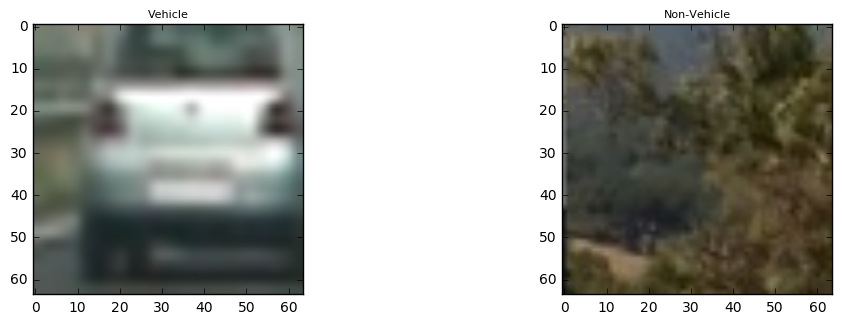

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

vehicle= glob.glob('../training_data/vehicles/*/*.png')
not_vehicle = glob.glob('../training_data/non-vehicles/*/*.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
f.tight_layout()
ax1.imshow(mpimg.imread(vehicle[100]))
ax1.set_title('Vehicle', fontsize=8)
ax2.imshow(mpimg.imread(not_vehicle[1]))
ax2.set_title('Non-Vehicle', fontsize=8)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

* I then explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the skimage.hog() output looks like.

Here is an example using the YCrCb color space and HOG parameters:  
orientations=9  
* pixels_per_cell=(8, 8)  
* cells_per_block=(2, 2)

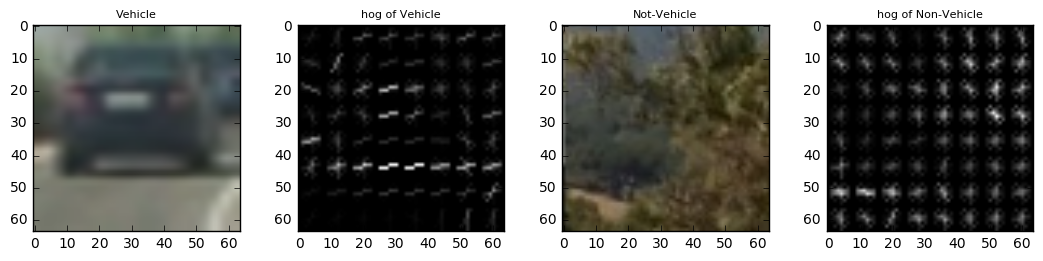

In [2]:
from functions.functions import *
#functions.py contains all the used functions for visualisation

feat_v, hog_img_vehicle = get_hog_features(cv2.cvtColor(cv2.imread(vehicle[1]), cv2.COLOR_BGR2GRAY), orient=9, pix_per_cell=8, 
                                 cell_per_block=2, vis=True, feature_vec=True)

feat_nv, hog_img_not_vehicle = get_hog_features(cv2.cvtColor(cv2.imread(not_vehicle[1]), cv2.COLOR_BGR2GRAY), orient=9, 
                                                pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))
f.tight_layout()
ax1.imshow(mpimg.imread(vehicle[1]))
ax1.set_title('Vehicle', fontsize=8)
ax2.imshow(hog_img_vehicle, cmap='gray')
ax2.set_title('hog of Vehicle', fontsize=8)
ax3.imshow(mpimg.imread(not_vehicle[1]))
ax3.set_title('Not-Vehicle', fontsize=8)
ax4.imshow(hog_img_not_vehicle, cmap='gray')
ax4.set_title('hog of Non-Vehicle', fontsize=8)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

Experimented with different combinations of color spaces and HOG parameters.  
Trained a linear SVM using different combinations of HOG features extracted from the selected color channels.  
* RGB was instantly discarded because of dependency on lighting conditions  
* HSV,YUV trained SVMs had problem detecting white vehicles  
* Finally, settled on YCrCb, as it gave the best detection results  
* pix_per_cells=8, cells_per_block=2  seemed ideal chodice for 64x64 scaled image  
* orient = 9, increasing didn't give any improvements in detection and decreasing causes loss of angle resolution  

## Feature Extraction
Zeroed in on following params after experimentaton:-

In [3]:
color_space = 'YCrCb'
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_feat = True
histogram_feat = True
hog_feat = True

## Data Augmentation and Training

* Used train_test_split from sklearn.model_selection to make 80-20 train-test split.  
* Then scaled the feature uisng sklearn.StandardScaler
* Trained LinearSVC on extracted features with default settings of square-hinged loss funcion and l2 normalization  
* code for this can be found in initial blocks of Training.ipynb  

## Pipeline for Vehicle Detection

### Sliding Windows

There are 2 methods for this as gathered from lecture videos and forums:-

1) generating hog features for complete image and then sliding windows over it for detection 
>* [implemented in find_cars function] in final_pipeline.py  
>* this method is faster because hog is computed only once  
>* I used the starter code provided in quiz for this function, but it seemed to give more false positives as compared to method (2) below  [this could be because of opencv resizing interpolation methods difference]  
>* modified provided starter code according to pipeline requirements
    
2) computing hog features for every window while iterating through windows 
>* slower brute alternative  
>* I used the starter code provided in quiz and modified according to requirement for pipeline

Method 1 was used for the video pipeline, on the basis of speed of computation (1 being faster than 2)

### Scales used for Sliding Windows

These values were determined empirically:-
>* (Window Sizes used, Corresponding scales): (64, 1) (96, 1.5) (128, 2) (160,2.5)  
>* Corresponding (ystart, ystop): (360,460)(360,560)(400,600)(400,700)

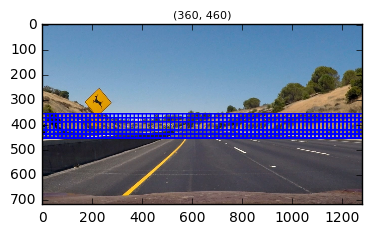

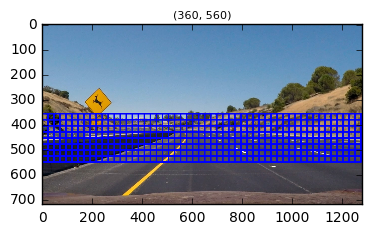

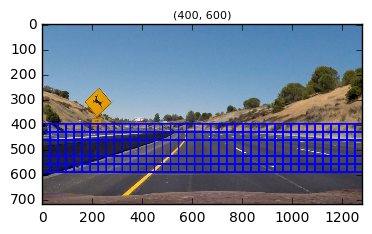

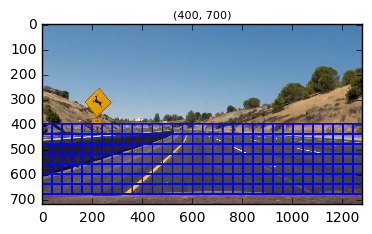

In [4]:
from functions.functions import *
import numpy as np
images = glob.glob('../test_images/*.jpg')

search_window_size = [64, 96, 128, 160]
y_bands = [(360,460),(360,560),(400,600),(400,700)]

windows = []
img = mpimg.imread(images[1])

for (i,yss) in zip(search_window_size,y_bands):
    temp = slide_window(img, 
                        x_start_stop=[0, img.shape[1]], 
                        y_start_stop=[yss[0], yss[1]], 
                        xy_window=(i,i), #square window
                        xy_overlap=(0.75, 0.75))
    windows = windows+temp
    f, (ax1) = plt.subplots(1, 1, figsize=(5, 2))
    f.tight_layout()
    ax1.imshow(draw_boxes(img, temp, color=(0, 0, 255), thick=6))
    ax1.set_title(yss, fontsize=8)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

### Vehicle Detection

Removed false positives using averaging the heat maps over multiple frames determined by bufferlen parameter as mentioned below
> * Pipeline class of final_pipeline.py does the vehicle detection in video

* it gets hog of required region at once, then slides windows to detect cars  
* the Pipeline Class in pipeline.py file has following attributes:-  

>* self.current_frame_number = 0  #keeps track of frame number  
>* self.svc_loaded = None  #loaded svc model  
>* self.color_space = 'YCrCb'  
>* self.spatial_size = (32,32)  
>* self.hist_bins = 32  
>* self.orient = 9  
>* self.pix_per_cell = 8  
>* self.cell_per_block = 2  
>* self.hog_channel = 'ALL'  
>* self.spatial_feat = True  
>* self.hist_feat = True  
>* self.hog_feat = True  
>* self.data_scaler = None  #the data scalre to scale extracted data  
>* self.heat_map_threshold = 4  #threshold for bounding box detection of heat maps  
>* self.debug = 0  #flag used for debug purpose to dump images within the pipeline  
>* self.ystartstop = [(360,460,1),(360,560,1.5),(400,600,2),(400,700,2.5)] #scaling factors for multiscale search  
>* self.bufferlen = 10 #length of buffer for multiple frames, to average heat maps over multiple frames to remove false positives  
>* self.heat_map_buffer = deque(maxlen=self.bufferlen) #heat map buffer  
>* self.bboxes=[] #to keep track of the bounding boxes   

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
images = glob.glob('../test_images/*.jpg')
%matplotlib inline

import pickle
from sklearn.preprocessing import StandardScaler
    
#model_data.pickle has model and data for scaler

with open('model-scaler.pickle', 'rb') as handle:
    loaded_feature_set = pickle.load(handle)
    data_scaler = loaded_feature_set['data_scaler']
    svc = loaded_feature_set['svc']
del loaded_feature_set    

[((550, 310), (1298, 650))]


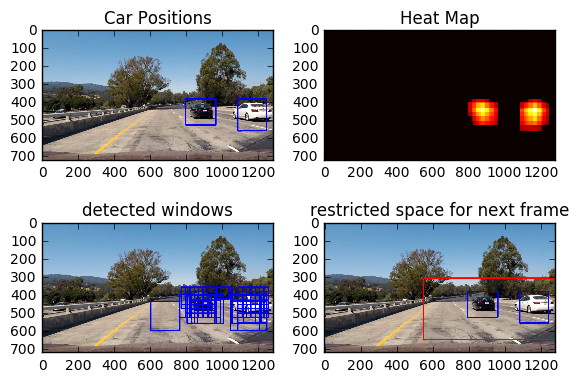

In [8]:
from functions.final_pipeline import *
import glob
images = glob.glob('../test_images/*.jpg')
P=Pipeline()
P.debug=1
P.data_scaler=data_scaler
P.svc_loaded=svc
P.ystartstop = [(360,460,1),(360,560,1.5),(400,600,2),(400,700,2.5)]

for i in images:
    img_final, heat_map, hot_boxes, restricted_space = P.Pipeline(mpimg.imread(i))
    fig = plt.figure()
    plt.subplot(221)
    plt.imshow(img_final)
    plt.title('Car Positions')
    plt.subplot(222)
    plt.imshow(heat_map, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(223)
    plt.imshow(hot_boxes)
    plt.title('detected windows')
    plt.subplot(224)
    plt.imshow(restricted_space)
    plt.title('restricted space for next frame')
    fig.tight_layout()
    P.heat_map_buffer.clear()
    P.bboxes=[]
    break

## Video Generation

To improve the processing speed for detecting cars in a video, similar to the Advanced Lane Lines project I implemented Look Ahead filter. 
>Video processing pipeline is implemented in the Pipeline function of Pipeline class in final_pipeline.py  
>a) It searches only around the detected areas once the car is detected   
>>1) this is done by keeping track of the previous frames bounding boxes  
>>2) to the (the minimum and maximum)coordinates of bounding boxes an extra 50 pixels are added to define a new reduced search area (displayed above)
>>3) next frame searches the cars in this reduced search area  

>b) And once every 24 frames (video appears to be 24fps => once every 1 second) does a full sweep across image to detect for new cars  


In [ ]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

P.heat_map_threshold=4
P.bufferlen=10
P.heat_map_buffer.clear() ##
P.bboxes=[] ##
P.current_frame_number=0
P.debug=0
P.data_scaler=data_scaler
P.svc_loaded=svc
P.ystartstop = [(360,460,1),(360,560,1.5),(400,600,2),(400,700,2.5)]

clip1 = VideoFileClip("..\project_video.mp4")
white_output = '..\project_video_output_final_submit_1.mp4'
white_clip = clip1.fl_image(P.Pipeline)
%time white_clip.write_videofile(white_output, audio=False)

## Discussion

> * The biggest problem for me was false positives, maybe using an ensemble of different algos along with svm might help.   
> * Like a neuralnet and a decision tree with highest weight to NN and the next highest to svm and lowest to decision tree.   
> * hard negative mining also can be used to improve svm performance, but did not use it here, as data would be only from provided videos, which migh put bias in favour of the provided videos being processed well but others not so good  
  
> * I tried to mitigate false positives using averaging over multiple frames and heat maps. As explained above in the notebook.  
  
> * Pipeline developed still is suboptimal as i'm still getting false positives in the processed video.  